# Poor Attendance

Student ID: B721581 | Data Completed: 22/01/23

The following is a Python program that uses the attendance records in the database to produce a table and a graph of students with poor attendance. The program does the following:
* Reads the relevant data from the SQL database
* Displays a table of the students with poorest attendance based on a selection criteria
* Given the Student ID's of 3 students with poor attendance, displays a graph of their attendance compared to module averages

**The validity checks for this task are built into the GUI menu**

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

## Functions

In [2]:
def get_att_data():
    """
    Gets the attendance data from the SQL database.
    
    input: None
    output: returns the attendance data dictionary
    
    db_name = name of database
    data = attendance data dictionary
    conn = connection to SQL database
    table_list = list of tables in the SQL database
    """

    # assign local variables and collections
    db_name = 'CWDatabase'
    data = {}
    
    
    ## read data from SQL database

    conn = sqlite3.connect(db_name + '.db')
    
    # get list of tables
    sqlstm = 'SELECT name FROM sqlite_master WHERE type = "table"'
    table_list = pd.read_sql(sqlstm, conn)
    table_list = list(table_list['name'])

    # loop through the list of tables and read in attendance data tables
    for table in table_list:
        if table[7:10] == 'att':
            data[table] = pd.read_sql('SELECT * FROM %s' %(table), conn)
            data[table] = data[table].drop(columns = 'index')
        else:
            continue

    conn.close()
    
    return data



def proccess_poor_att(data):
    """
    Processes the attendance data into poor attendance data,
    ready for creating the table and graph.
    
    input: attendance data dictionary
    output: unformatted dataframe of students with poorest attendance
            & dictionary of lists of average weekly attendance for each module
            & list of column names
            & value for average weekly attendance for the department 
    
    data = attendance data dictionary
    att_dic = attendance data dictionary of attendance % per week per student
    att_dic_concat = concatenated att_dic
    by_row_index = helps to calculate average attendance 
    comb_att_dic = combined att_dic (average attendance per module)
    module_mean_att = dictionary of lists of average weekly attendance 
                      for each module
    col_name_list = list of column names
    dept_avg = average weekly attendance for the department (all modules)
    selection_criteria = criteria for selection of students 
                         with poorest attendance
    week_no_list = list of week numbers
    sid_list = list of Student ID's
    poor_att = unformatted dataframe of students with poorest attendance
    """
    
    # assign local variables and collections
    att_dic = {}
    module_mean_att = {}
    col_name_list = []

    # loop through attendance data dictionary
    for name, df in data.items():

        # assign local variables and collections within loop
        sid_list = []

        # get list of week numbers
        week_no_list = [item[4:5] for item in list(df.columns)]
        week_no_list[0] = 'sid'

        # reshape dataframe and calculate attendance %
        df.columns = week_no_list
        df = df.transpose()
        df.reset_index(inplace = True)
        df.rename(columns = {'index':'week'}, inplace = True)
        df = df.groupby('week').mean()
        df = df * 100
        df.loc['sid'] = df.loc['sid'] / 100
        df = df.transpose()
        sid_list = df['sid'].tolist()
        df.drop(columns = ['sid'], inplace = True)
        att_dic[name] = df
        
        # add list of mean attendance per week to module_mean_att dictionary
        module_mean_att[name] = list(round(df.mean(), 1))

    # combine dataframes in att_dic 
    # and calculate mean attendance % over all modules
    att_dic_concat = pd.concat(att_dic.values())
    by_row_index = att_dic_concat.groupby(att_dic_concat.index)
    comb_att_dic = by_row_index.mean()

    # rename column headings and save them to col_name_list
    comb_att_dic = comb_att_dic.add_prefix('Week ').add_suffix(' %')
    col_name_list = list(comb_att_dic.columns)
    
    # calculate dept_avg and selection_criteria
    # use selection_criteria to create poor_att
    comb_att_dic.loc['mean'] = comb_att_dic.mean()
    comb_att_dic['Average %'] = comb_att_dic.mean(numeric_only = True, 
                                                  axis = 1)
    dept_avg = round(comb_att_dic['Average %'].loc['mean'], 1)
    selection_criteria = dept_avg / 2
    comb_att_dic.drop(axis = 0, index = 'mean', inplace = True)
    comb_att_dic.insert(0, 'Student ID', sid_list)
    comb_att_dic = comb_att_dic.sort_values('Average %')
    poor_att = comb_att_dic[comb_att_dic['Average %'] < selection_criteria]

    return poor_att, module_mean_att, col_name_list, dept_avg



def poor_att_table(poor_att, dept_avg, col_name_list):
    """
    Displays a table of the students with the poorest weekly 
    attendance according to the selection criteria.

    input: unformatted dataframe of students with poorest attendance
           & value for average weekly attendance for the department 
           & list of column names
    output: displays the formatted table
    
    poor_att = unformatted dataframe of students with poorest attendance
    poor_att_table = formatted dataframe of students with poorest attendance
    col_name_list = list of column names
    dept_avg = average weekly attendance for the department (all modules)
    table_title = title string for the table caption
    color_above_dept_avg() = function used for conditional formatting
    """
    
    
    def color_above_dept_avg(value):
        '''
        Conditionally formats the 'value' if it is > the dept_avg.

        input: value or subset of values to be formatted
        output: formatted background colour
        
        value = value or subset of values
        dept_avg = average weekly attendance for the department (all modules)
        colour = background colour
        '''
        colour = ''

        if value > dept_avg:
            colour = 'lightgreen'

        return 'background-color: %s' % colour


    # format the dataframe
    table_title = 'Table of Students with Poorest Weekly Attendance \
    (Selection Criteria is 50%% below \
    the Department Average: %s%%)' %(str(dept_avg))
    poor_att_table = poor_att.style\
                             .format('{:.1f}')\
                             .format('{:.0f}', subset = ['Student ID'])\
                             .applymap(color_above_dept_avg, 
                                       subset = col_name_list)\
                             .set_caption(table_title)\
                             .set_table_styles([{'selector': 'caption',
                                                 'props': [('font-size', 
                                                            '18px')]}])\
                             .hide_index()

    display(poor_att_table)



def poor_att_plot(module_mean_att, poor_att, sid1, sid2, sid3):
    """
    Displays a graph of the average weekly attendance per module and 
    the average weekly attendance of 3 given Student IDs.

    input: dictionary of lists of average weekly attendance for each module
           & unformatted dataframe of students with poorest attendance
           & 3 Student IDs
    output: displays the graph
    
    module_mean_att = dictionary of lists of average weekly attendance 
                      for each module
    poor_att = unformatted dataframe of students with poorest attendance
    sid1, sid2, sid3 = 3 Student IDs
    module_att_plot = dataframe to plot average weekly attendance 
                      for each module 
    module_list = list of modules
    sid_poor_att_plot = dataframe to plot average weekly attendance 
                        of 3 given Student IDs
    """
    
    # assign local variables and collections
    module_att_plot = pd.DataFrame()
    module_list = []
    
    # create dataframe with average weekly attendance per module 
    # and get list of modules
    module_att_plot = pd.DataFrame.from_dict(module_mean_att, orient = 'index')
    module_att_plot = module_att_plot.transpose()    
    module_att_plot.columns = module_att_plot.columns.str.rstrip('_att_data')
    module_list = list(module_att_plot.columns)
    module_att_plot['Week No'] = np.arange(len(module_att_plot)) + 1

    # create dataframe with average weekly attendance per student
    sid_poor_att_plot = poor_att.transpose()
    sid_poor_att_plot.columns = sid_poor_att_plot.iloc[0]
    sid_poor_att_plot = sid_poor_att_plot.drop(['Student ID','Average %'])
    sid_poor_att_plot.reset_index(drop = True, inplace = True)
    sid_poor_att_plot['Week No'] = np.arange(len(sid_poor_att_plot)) + 1
    
    # if (int(sid1) or int(sid2) or int(sid3)) not in list(sid_poor_att_plot.columns):
    #     raise Exception
    
    # plot average weekly attendance per module as lines
    module_att_plot.plot(x = 'Week No', 
                         y = module_list, 
                         kind = 'line', 
                         title = 'Graph of Average Weekly Attendance',
                         ylabel = 'Average Attendance (%)',
                         rot = 0,
                         ylim = [-5, 105])

    # plot average weekly attendance of 3 poor students as dots
    plt.plot(sid_poor_att_plot['Week No'], 
             sid_poor_att_plot[int(sid1)], 
             'r.', 
             label = str(sid1).strip())

    plt.plot(sid_poor_att_plot['Week No'], 
             sid_poor_att_plot[int(sid2)], 
             'm.', 
             label = str(sid2).strip())
    
    plt.plot(sid_poor_att_plot['Week No'], 
             sid_poor_att_plot[int(sid3)], 
             'g.', 
             label = str(sid3).strip())

    # set legend position
    plt.legend(bbox_to_anchor = (1.01, 1.0), loc = 'upper left')

    plt.show()

## Main Functions

In [3]:
def get_poor_table():
    """
    Combines some of the above functions into one function 
    that displays a table:
        - Reads the data from the SQL database,
          proccesses the data and creates the table
    
    input: None
    output: None
    
    poor_att = unformatted dataframe of students with poorest attendance
    module_mean_att = dictionary of lists of average weekly attendance 
                      for each module
    col_name_list = list of column names
    dept_avg = average weekly attendance for the department (all modules)
    """
    
    poor_att, module_mean_att, col_name_list, dept_avg = proccess_poor_att(
                                                             get_att_data())
        
    poor_att_table(poor_att, dept_avg, col_name_list)

    

def get_poor_graph(sid1, sid2, sid3):
    """
    Combines some of the above functions into one function 
    that displays a graph:
        - Reads the data from the SQL database,
          proccesses the data and creates the graph
    
    input: 3 Student IDs
    output: None
    
    poor_att = unformatted dataframe of students with poorest attendance
    module_mean_att = dictionary of lists of average weekly attendance 
                      for each module
    col_name_list = list of column names
    dept_avg = average weekly attendance for the department (all modules)
    sid1, sid2, sid3 = 3 Student IDs
    """
    
    poor_att, module_mean_att, col_name_list, dept_avg = proccess_poor_att(
                                                             get_att_data())
                    
    poor_att_plot(module_mean_att, poor_att, sid1, sid2, sid3)

## Functions Demo

Student ID,Week 1 %,Week 2 %,Week 3 %,Week 4 %,Week 5 %,Week 6 %,Average %
242,0.0,0.0,0.0,0.0,nan,nan,0.0
190,0.0,0.0,0.0,0.0,nan,nan,0.0
54,0.0,0.0,0.0,nan,nan,nan,0.0
18,0.0,0.0,0.0,nan,nan,nan,0.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,0.0,25.0,0.0,0.0,0.0,0.0,4.2
70,25.0,0.0,0.0,0.0,0.0,0.0,4.2
43,0.0,25.0,25.0,0.0,0.0,0.0,8.3
173,50.0,0.0,0.0,0.0,0.0,0.0,8.3
24,25.0,0.0,0.0,0.0,25.0,0.0,8.3


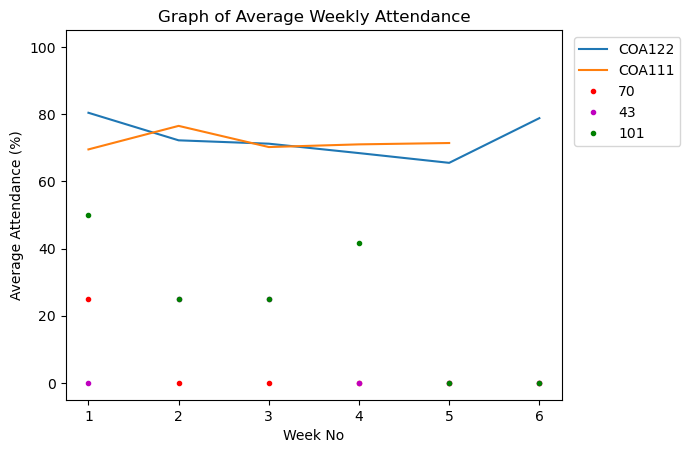

In [4]:
get_poor_table()  

get_poor_graph(70, 43, 101)